# pixel-shuffle

## setup

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import animation
import scipy
from scipy import optimize
import numpy as np
from tqdm.notebook import trange, tqdm

In [2]:
rng = np.random.default_rng()

In [3]:
skel_img = Image.open("./images/elephants.jpg")
fill_img = Image.open("./images/chameleon.jpg")

In [4]:
dims = skel_img.size
fill_img = fill_img.resize(dims)

In [5]:
skel_arr = np.asarray(skel_img)
fill_arr = np.asarray(fill_img)

In [6]:
rows, cols, _ = skel_arr.shape

## generate pixel shuffle

In [12]:
O = 25

r = rows // O
c = cols // O
        
cost_matrix = np.empty((r,c,r,c))

In [13]:
for i in trange(r):
    for j in trange(c, leave=False):
        avg_skel = np.average(skel_arr[i*O:i*O+O, j*O:j*O+O], axis=(0,1))
        for i2 in range(r):
            for j2 in range(c):
                avg_fill = np.average(fill_arr[i2*O:i2*O+O, j2*O:j2*O+O], axis=(0,1))
                cost_matrix[i,j,i2,j2] = np.linalg.norm(avg_fill - avg_skel)


temp = cost_matrix.reshape(r, c, r*c).transpose(2,0,1).reshape(r*c, r*c).transpose(1,0)
_, col_ind = optimize.linear_sum_assignment(temp)

coords = col_ind.reshape(r,c)

In [14]:
final_arr = np.empty((rows, cols, 3), dtype=int)

for i in range(r):
    for j in range(c):
        temp = coords[i,j]
        i2 = temp // c
        j2 = temp % c
        
        final_arr[i*O:i*O+O, j*O:j*O+O] = fill_arr[i2*O:i2*O+O, j2*O:j2*O+O].copy()

In [15]:
interp_coef = 50
interp_arrs = np.zeros((interp_coef, rows, cols, 3), dtype=int)
interp_domain = np.linspace(0, 1, num=interp_coef)

for k, val in enumerate(tqdm(interp_domain)):
    for i in range(r):
        for j in range(c):
            temp = coords[i,j]
            i2 = temp // c
            j2 = temp % c
            
            i3 = int(i * (1 - val) + i2 * val)
            j3 = int(j * (1 - val) + j2 * val)

            interp_arrs[k, i*O:i*O+O, j*O:j*O+O] = fill_arr[i3*O:i3*O+O, j3*O:j3*O+O].copy()

## display results

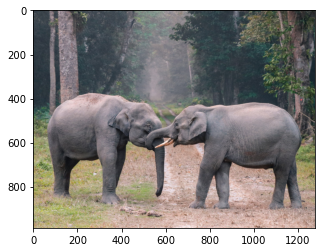

In [22]:
%matplotlib inline
plt.imshow(skel_arr);

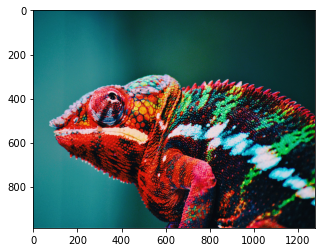

In [23]:
%matplotlib inline
plt.imshow(fill_arr);

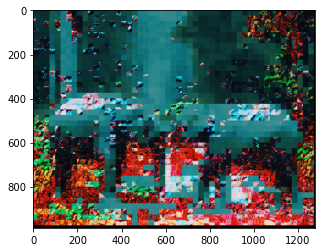

In [24]:
%matplotlib inline
plt.imshow(final_arr);

<IPython.core.display.Javascript object>


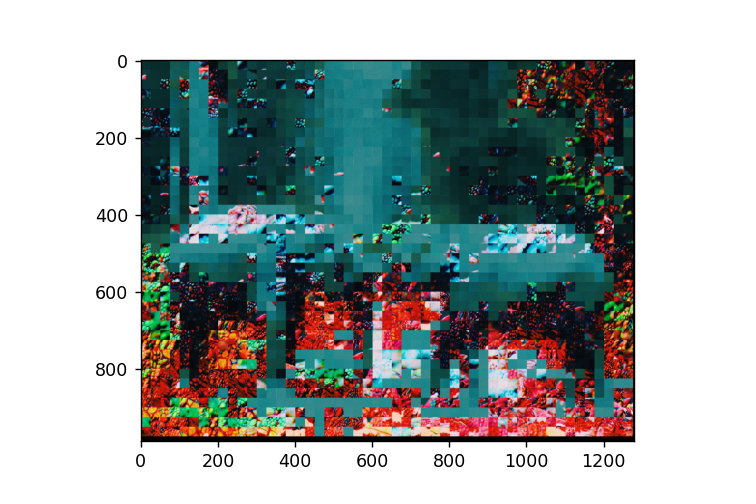

In [28]:
%matplotlib notebook
fig = plt.figure()

plt.imshow(final_arr)

ims = []
for k in range(interp_coef):
    im = plt.imshow(interp_arrs[k], animated=True)
    ims.append([im])


ani = animation.ArtistAnimation(fig, ims, interval=40, blit=True, repeat_delay=5000)

plt.show()

In [34]:
# ani.save("pixel-shuffle.gif", writer="pillow")